In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import reduce      
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

In [273]:
data = pd.read_csv('oehd_pronovo2.csv',na_values=['NA', 'N/A', 'nan', ''], low_memory=False)    

data_clean = data.dropna(subset=['inbetriebnahme'])
data_clean.loc[:,'Date'] =pd.to_datetime(data_clean.loc[:,"inbetriebnahme"]).dt.date
data_clean.sort_values(['Date'], ascending=[True],inplace=True)


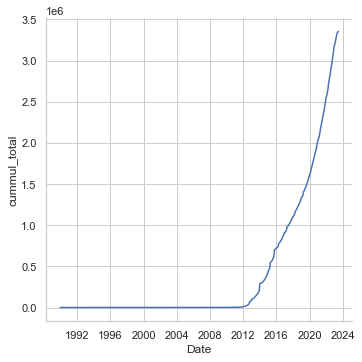

In [274]:

data_clean['cummul_total'] = data_clean['realisierte_leistung_inkl_erweiterungen'].cumsum()
sns.set(font_scale=1)
sns.set_style("whitegrid")
g = sns.relplot(x="Date", y="cummul_total",data=data_clean,kind="line",ci=None)


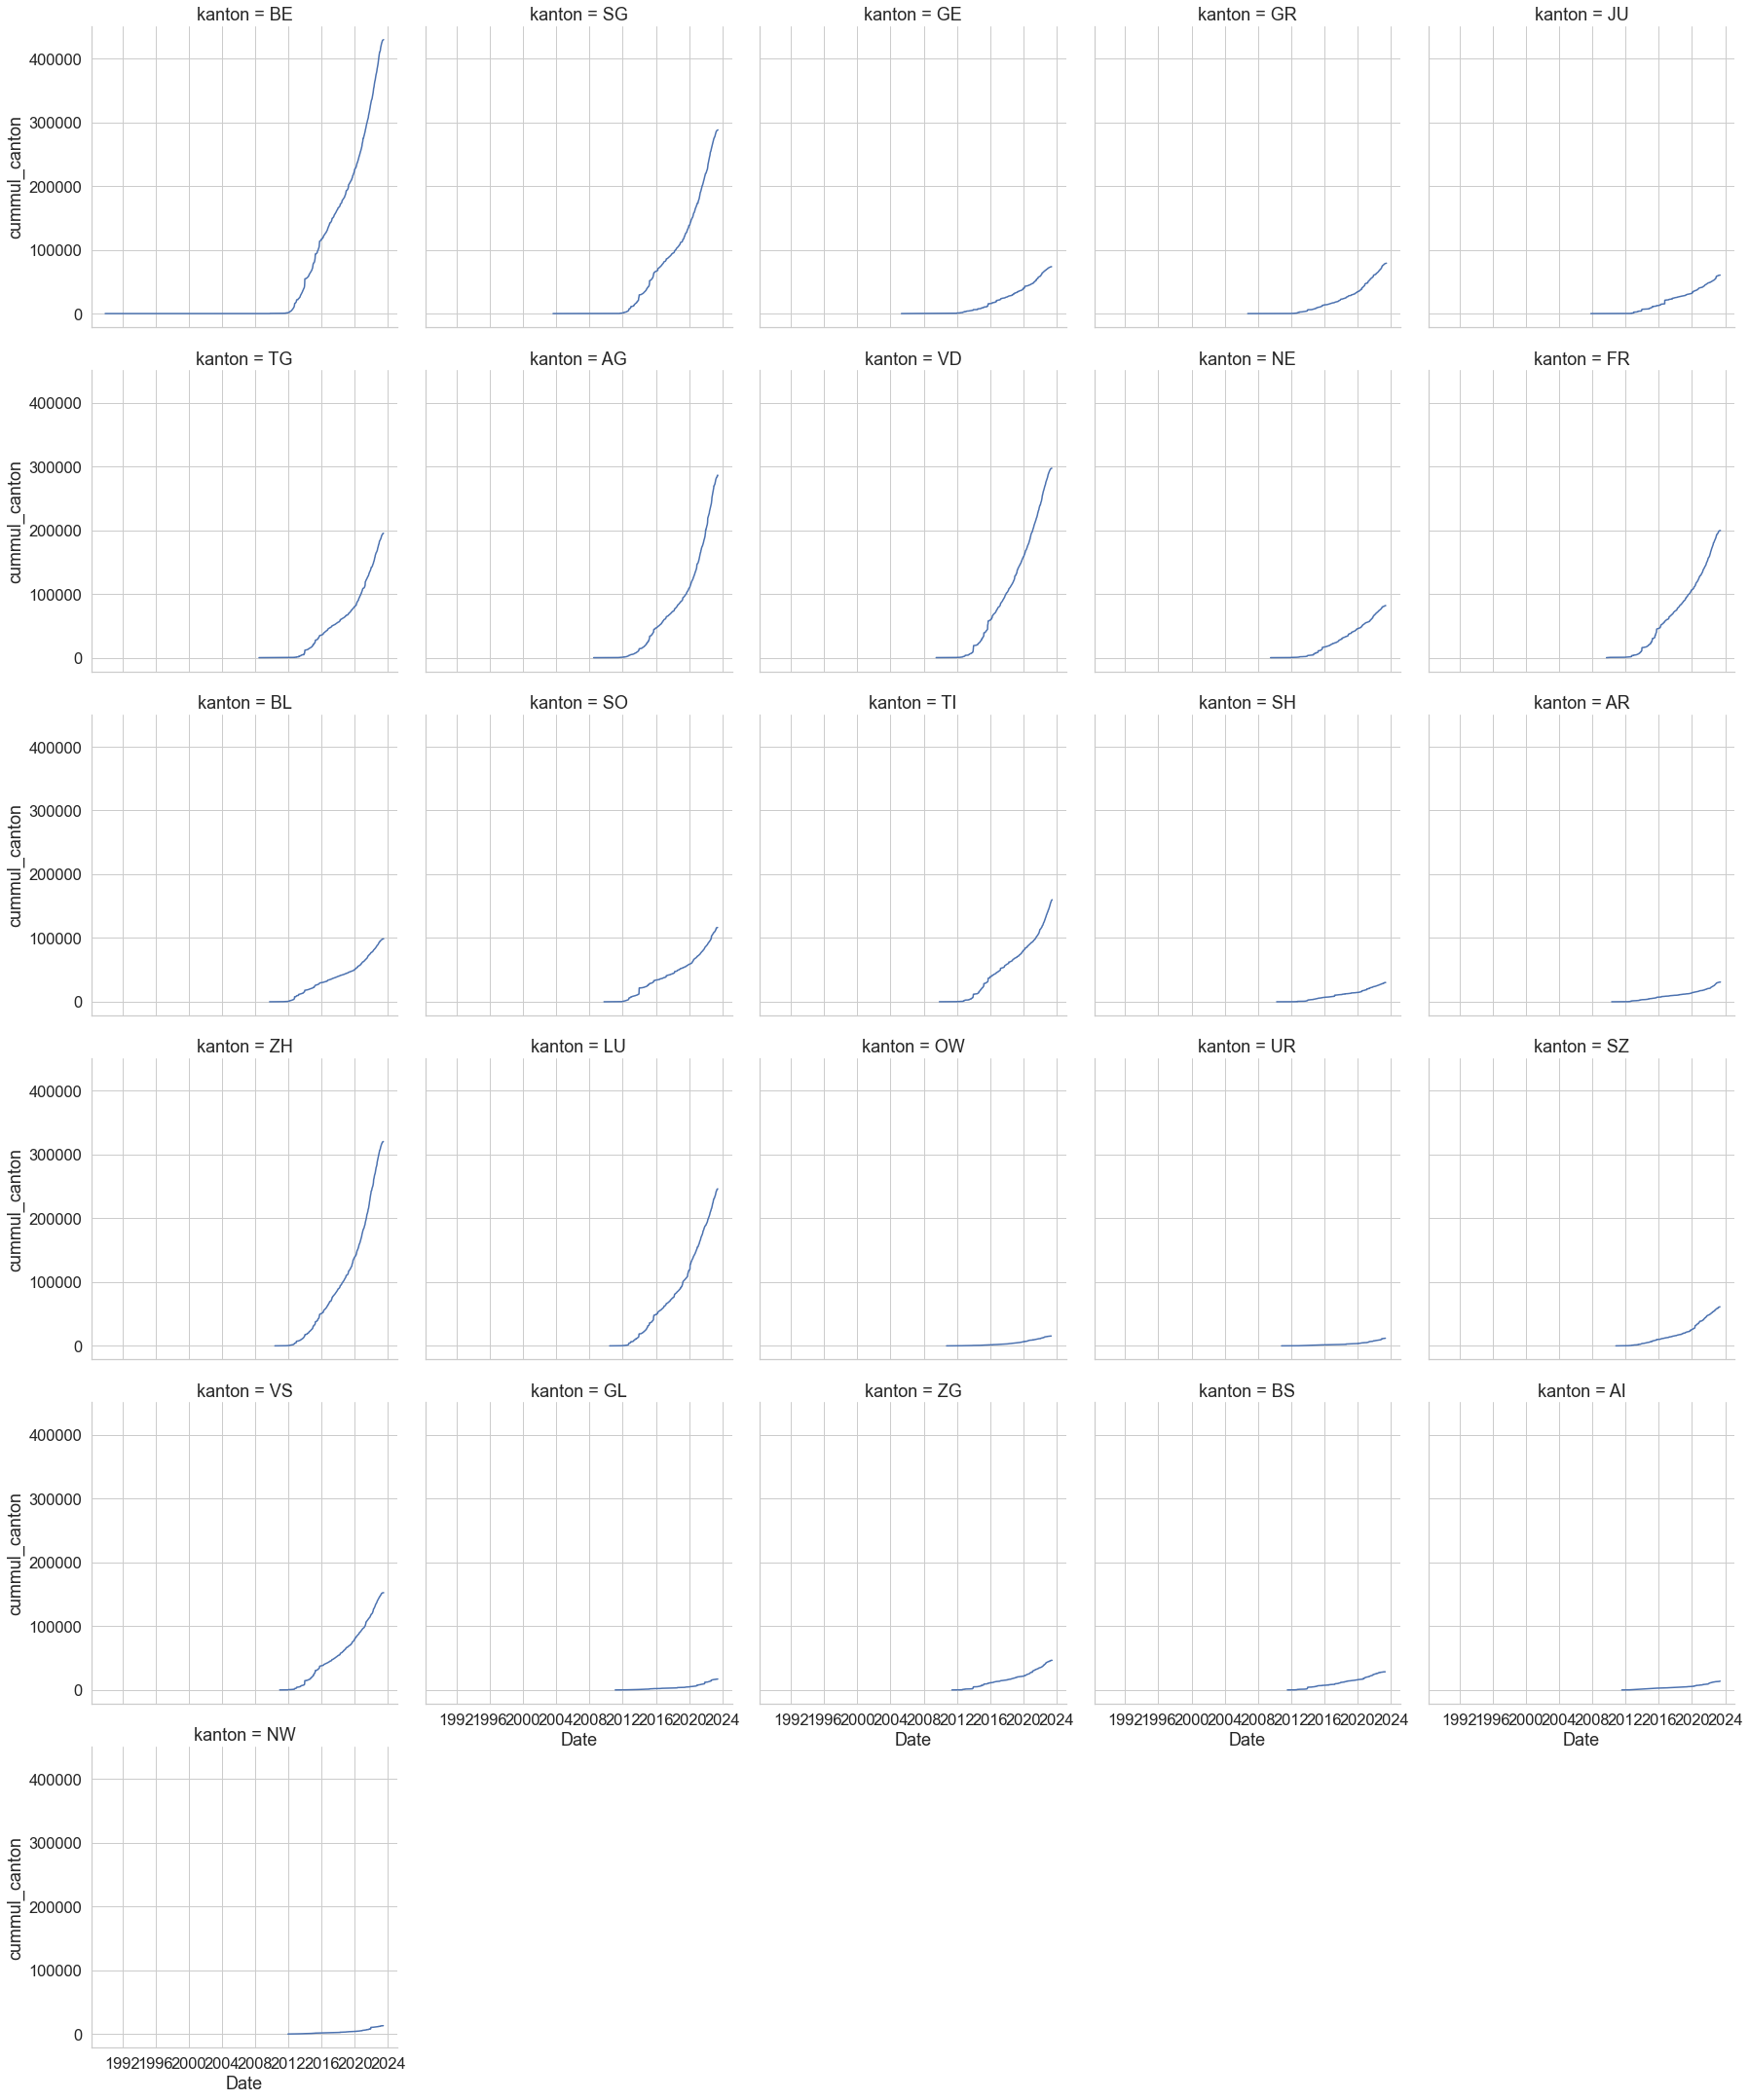

In [275]:
# Print the data by canton
data_clean['cummul_canton'] = data_clean.groupby('kanton')['realisierte_leistung_inkl_erweiterungen'].cumsum()
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
# g = sns.relplot(x="Date", y="cummul_canton", col="kanton",data=data_clean.loc[data_clean['kanton']=='ZH'],hue="kanton",kind="line")

g = sns.relplot(x="Date", y="cummul_canton",data=data_clean,col="kanton",col_wrap=5,kind="line",ci=None)

<AxesSubplot:xlabel='Date', ylabel='cummul_total'>

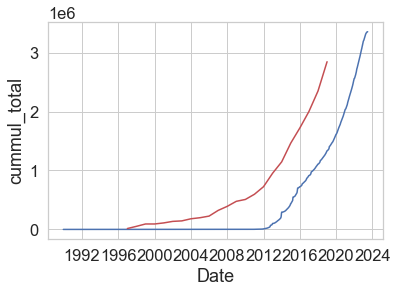

In [276]:
# EWZ data

# From pronovo

data_clean_company = data_clean.dropna(subset=['name_netzbetreiber'])

data_clean_company['cummul_company'] = data_clean_company.groupby('name_netzbetreiber')['realisierte_leistung_inkl_erweiterungen'].cumsum()
#sns.set(font_scale=1)
#sns.set_style("whitegrid")
#g = sns.relplot(x="Date", y="cummul_company",data=data_clean_company.loc[data_clean_company['name_netzbetreiber'].str.contains('ewz')],kind="line",ci=None)

# From EWZ
data_from_ewz = pd.read_csv('ewz.csv')    
data_from_ewz['cummul_total'] = data_from_ewz['ins_capacity'].cumsum()
data_from_ewz['cummul_total'] = data_from_ewz['cummul_total']*100
data_from_ewz.loc[:,'Date'] = pd.to_datetime(data_from_ewz['year'].astype(str), format='%Y')

fig, ax = plt.subplots()
sns.lineplot(x='Date', y='cummul_total', data=data_clean_company, ax=ax,ci=None)
sns.lineplot(x='Date', y='cummul_total', data=data_from_ewz, ax=ax, color='r')

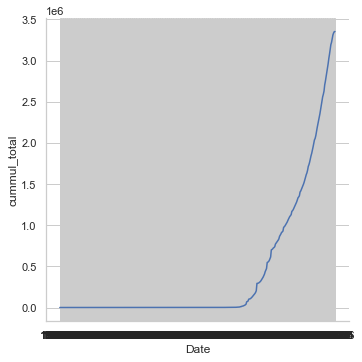

In [277]:
# Aggregate the pronovo data by month

# copy the data
pronovo = data_clean[['Date', 'realisierte_leistung_inkl_erweiterungen']].copy()
pronovo['Date']= pd.to_datetime(pronovo['Date'])
pronovo.set_index('Date',inplace=True)

pronovo_month =pronovo.groupby(pd.Grouper(freq="M")).sum()

pronovo_month = pronovo_month.reset_index()
pronovo_month['Date'] = pronovo_month['Date'].apply(lambda x: x.strftime('%Y-%m'))
pronovo_month.set_index('Date', inplace=True)

pronovo_month['cummul_total'] = pronovo_month['realisierte_leistung_inkl_erweiterungen'].cumsum()

sns.set(font_scale=1)
sns.set_style("whitegrid")
g = sns.relplot(x="Date", y="cummul_total",data=pronovo_month,kind="line",ci=None)

In [220]:
# Load the BFE data

bfe = pd.read_csv('installed_capacity_sfoe.csv',na_values=['NA', 'N/A', 'nan', ''], low_memory=False)    

bfe.loc[:,'Date'] =pd.to_datetime(bfe.loc[:,"date"]).dt.date
bfe['Date'] = bfe['Date'].apply(lambda x: x.strftime('%Y-%m'))
bfe.set_index('Date', inplace=True)

bfe['SFOE_month']= bfe['SFOE'].diff()
bfe.loc['2008-01','SFOE_month']= bfe.loc['2008-01','SFOE']

#Change units
bfe['SFOE_month']= bfe['SFOE_month']*1000


bfe.sort_values(['Date'], ascending=[True],inplace=True)
bfe

,date,SFOE,EQ,Estimate,SFOE_month
Date,,,,,
2008-01,2008-01-01,37.4,35.00,False,37400.0
2008-02,2008-02-01,38.4,35.92,True,1000.0
2008-03,2008-03-01,39.4,36.83,True,1000.0
2008-04,2008-04-01,40.4,37.75,True,1000.0
2008-05,2008-05-01,41.4,38.67,True,1000.0
...,...,...,...,...,...
2024-09,2024-09-01,7200.0,6049.00,True,125000.0
2024-10,2024-10-01,7325.0,6124.00,True,125000.0
2024-11,2024-11-01,7450.0,6199.00,True,125000.0


<AxesSubplot:xlabel='Date'>

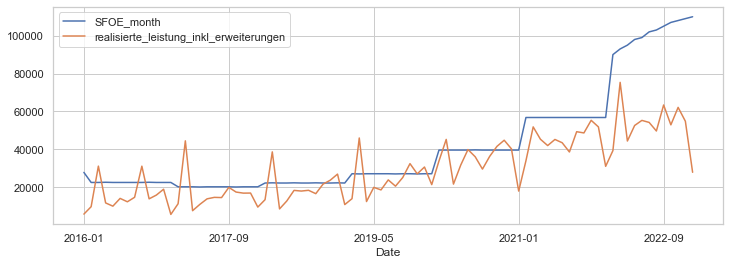

In [281]:
# Put monthly data in the same dataframe

montly = pd.concat([bfe, pronovo_month], axis=1).dropna(subset=['realisierte_leistung_inkl_erweiterungen'])
montly.drop(columns=['date', 'EQ','Estimate','cummul_total','SFOE'],inplace=True)

start = '2016-01'
end = '2023-01'


montly = montly.loc[start:end]
montly.plot.line(figsize=(12, 4,))

<AxesSubplot:xlabel='Date'>

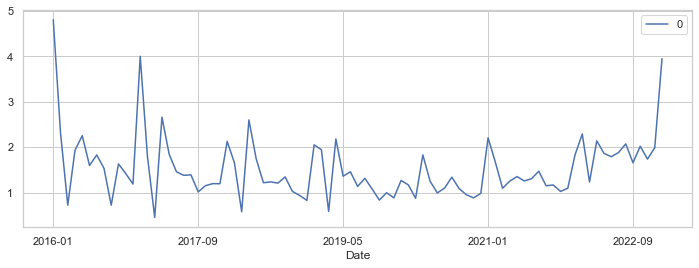

In [283]:
# Calculate the montly correction factor

x = (montly.SFOE_month / montly.realisierte_leistung_inkl_erweiterungen).to_frame()
x.plot.line(figsize=(12, 4,))

<AxesSubplot:xlabel='Date'>

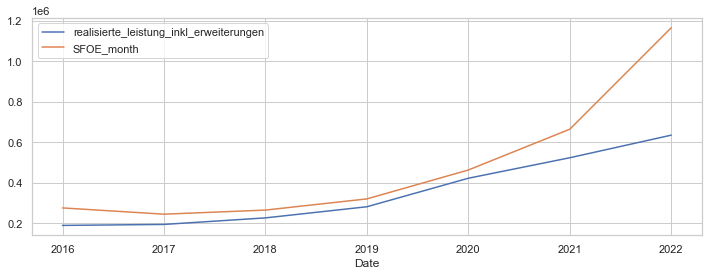

In [313]:
# Aggregate the pronovo and BFE data by year

pronovo_year =pronovo.groupby(pd.Grouper(freq="Y")).sum()
pronovo_year = pronovo_year.reset_index()
pronovo_year['Date'] = pronovo_year['Date'].apply(lambda x: x.strftime('%Y'))
pronovo_year.set_index('Date', inplace=True)

bfe_copy = bfe.copy()
bfe_copy.drop(columns=['date', 'EQ','Estimate','SFOE'],inplace=True)
bfe_copy = bfe_copy.reset_index()

bfe_copy.loc[:,'Date'] =pd.to_datetime(bfe_copy.loc[:,"Date"])
bfe_copy.set_index('Date', inplace=True)

bfe_year =bfe_copy.groupby(pd.Grouper(freq="Y")).sum()
bfe_year = bfe_year.reset_index()
bfe_year['Date'] = bfe_year['Date'].apply(lambda x: x.strftime('%Y'))
bfe_year.set_index('Date', inplace=True)


yearly = pd.concat([pronovo_year, bfe_year], axis=1).dropna(subset=['realisierte_leistung_inkl_erweiterungen'])
start = '2016'
end = '2022'


yearly = yearly.loc[start:end]
yearly.plot.line(figsize=(12, 4,))


,0
Date,
2016,1.457603
2017,1.260683
2018,1.170665
2019,1.137838
2020,1.096449
2021,1.269463
2022,1.835745


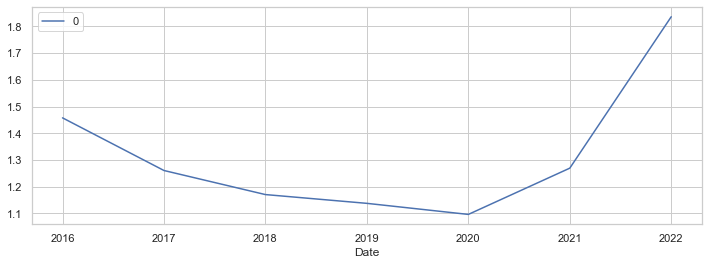

In [315]:
# Calculate the yearly correction factor

x_year = (yearly.SFOE_month / yearly.realisierte_leistung_inkl_erweiterungen).to_frame()
x_year.plot.line(figsize=(12, 4,))
x_year